# Hypothesis Testing with Insurance Data

## Task
- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

For each question, make sure to:

- State your Null Hypothesis and Alternative Hypothesis
- Select the correct test according to the data type and number of samples
- Test the assumptions of your selected test.
- Execute the selected test, or the alternative test (if you do not meet the assumptions)
- Interpret your p-value and reject or fail to reject your null hypothesis 
- Show a supporting visualization that helps display the result

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### Upload Data

In [2]:
df = pd.read_csv('Data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Q1. Do smokers have higher insurance charges than non-smokers?

- $H_0$ Null Hypothesis: There is no difference between the insurance charges of smokers vs non-smoker.

-  $H_1$ Alternate hypothesis: There is a higher insurance charge for smokers vs non-smokers.

- Alpha:  We will be using an alpha=.05

- Test of Choice: Independent t-test (2-sample)

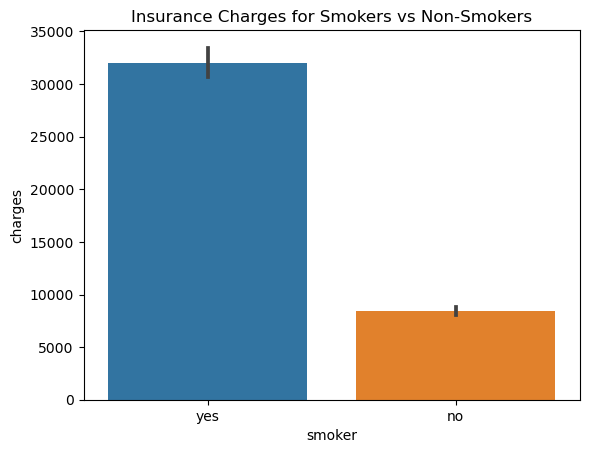

In [3]:
#visualization
ax = sns.barplot(data=df, x='smoker',y='charges')
ax.set_title("Insurance Charges for Smokers vs Non-Smokers");

In [4]:
#filter out smokers vs non-smokers
smokers = df.loc[df['smoker']=='yes']
non_smokers = df.loc[df['smoker']=='no']

In [5]:
#feature of interest
smoker_charges = smokers['charges']
non_smoker_charges = non_smokers['charges']

In [6]:
## Getting means and lenghs
print(f"For Smokers (n={len(smoker_charges)}): Mean={np.mean(smoker_charges):.2f}")
print(f"For Non-Smokers (n={len(non_smoker_charges)}): Mean={np.mean(non_smoker_charges):.2f}")

For Smokers (n=274): Mean=32050.23
For Non-Smokers (n=1064): Mean=8434.27


> Checking for Outliers

In [7]:
#checking for outliers for smokers
smoker_outliers = abs(stats.zscore(smoker_charges))>3
np.sum(smoker_outliers)

0

In [8]:
#checking for outliers for non-smokers
nonsmoker_outliers = abs(stats.zscore(non_smoker_charges))>3
np.sum(nonsmoker_outliers)

24

In [9]:
#remove outliers for non-smokers
#removing the outliers by filtering them out
non_smoker_charges = non_smoker_charges.loc[~nonsmoker_outliers]
len(non_smoker_charges)

1040

> Checking for Normality

In [10]:
# normal test for smokers
result_smokers = stats.normaltest(smoker_charges)
result_smokers

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [11]:
# normal test for non-smokers
result_nonsmokers = stats.normaltest(non_smoker_charges)
result_nonsmokers

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

- For both groups p is less than 0.05 so we can assume these are NOT normal distributions, however, since each group has greater than 15 samples we can safely ignore the assumption of normality and proceed.

> Checking for Equal Variance

In [12]:
result = stats.levene(smoker_charges, non_smoker_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

- Since our p-value was less than .05 we reject the null hypothesis that the samples come from populations with equal variances. Since our groups DO NOT have equal variance, in our test we will need to set equal_var =False (default value is True)

> T-Test

In [13]:
result = stats.ttest_ind(smoker_charges, non_smoker_charges, equal_var=False)
## is our result significant
print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue <.05}")

p-value=0.0000000000
Significant: True


### Conclusion

Based on our t-test (p < 0.05), we have a significant result. In conclusion, we reject the null hypothesis and accept the alternative hypothesis that there IS a higher insurance charge for smokers vs non-smokers.

### Q2. Are men more likely to smoke than women?

- $H_0$ Null Hypothesis: There is no difference between the likelyhood of smoking between genders.

-  $H_1$ Alternate hypothesis: A person's gender does influence their likelyhood of being a smoker vs non-smoker.

- Alpha:  We will be using an alpha=.05

- Test of Choice: Chi-Squared

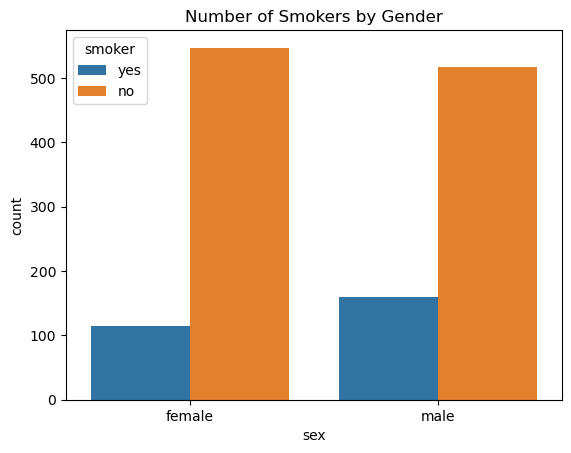

In [14]:
#visualization
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Gender");

In [15]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [16]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [17]:
result

(7.39291081459996,
 0.006548143503580696,
 1,
 array([[526.43348281, 135.56651719],
        [537.56651719, 138.43348281]]))

In [18]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

### Conclusion
- Since our p value is less than .05 (p < .05), we reject the null hypothesis that there is no difference between the likelyhood of smoking between genders.
- This means that we accept the alternate hypothesis and conclude that a person's gender DOES influence their likelyhood of being a smoker vs non-smoker.

### Q3. Do different regions have different charges, on average?

- $H_0$ Null Hypothesis: On average there is no difference in insurance charges for different regions.

-  $H_1$ Alternate hypothesis: On average there is a difference in insurance charges for different regions.

- Alpha:  We will be using an alpha=.05

- Test of Choice: One Way ANOVA and/or Tukey

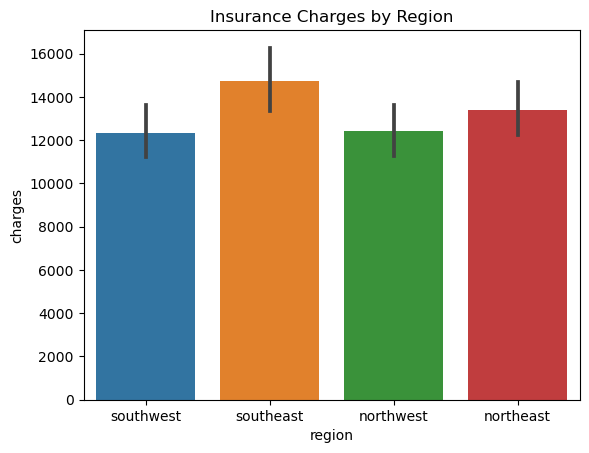

In [19]:
#visualization
ax = sns.barplot(data=df, x='region',y='charges')
ax.set_title("Insurance Charges by Region");

In [20]:
## Create groups dictionary
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

> Checking for Normality

In [21]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [22]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


- We DID NOT meet the assumption of normality but as long as our population is large enough (in this case, between 2-9 groups and each group n >= 15), we can take advantage of tests that assume a normal distribution.

> Checking for Equal Variance

In [23]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

- We DID NOT meet the assumption of equal variance and will therefore need to use the nonparametric test:Kruskal-Wallis.

In [26]:
#kruskal test
result = stats.kruskal(*groups.values())
result

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

### Conclusion

Our p value is greater than 0.05 which means that we fail to reject the null hypothesis that on average there is no difference in insurance charges for different regions.